# Process Renovar CO Data according to reference station

## Constants and imports

In [118]:
input_data_directory = 'data/output/'
SENSOR_NAME = 'alpha_co_conc'
sensor_data_path = input_data_directory + SENSOR_NAME + '_dataframe.csv'
temperature_data_path = input_data_directory + 'chamber_tempdataframe.csv'
temperature_data_path_1HR = input_data_directory + 'chamber_tempdataframe_1hr.csv'

## Load Alphasense CO sensor data

In [119]:
import pandas as pd

sensor_data = pd.read_csv(sensor_data_path)
sensor_data['DateTime'] = pd.to_datetime(sensor_data['DateTime'], infer_datetime_format=True)
sensor_data = sensor_data.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_data.index = sensor_data['DateTime']
sensor_data = sensor_data.drop(columns='DateTime')
sensor_data = sensor_data[['value', 'Tag', 'Hour']].rename(columns={'value': 'measuring'})
sensor_data.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_99419/1999137852.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  sensor_data['DateTime'] = pd.to_datetime(sensor_data['DateTime'], infer_datetime_format=True)


,measuring,Tag,Hour
DateTime,,,
2022-11-20 13:45:00,NaN,STABILIZING,13
2022-11-20 14:00:00,NaN,STABILIZING,14
2022-11-20 14:15:00,NaN,STABILIZING,14
2022-11-20 14:30:00,NaN,STABILIZING,14
2022-11-20 14:45:00,NaN,STABILIZING,14


## Load sensor chamber temperature data

In [120]:
import pandas as pd

temperature_data = pd.read_csv(temperature_data_path)
temperature_data['DateTime'] = pd.to_datetime(temperature_data['DateTime'], infer_datetime_format=True)
temperature_data = temperature_data.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
temperature_data.index = temperature_data['DateTime']
temperature_data = temperature_data.drop(columns='DateTime')
temperature_data = temperature_data[['measuring', 'Tag']]
temperature_data = temperature_data.rename(columns={'measuring': 'temperature', 'Tag': 'Temperature Tag'})
temperature_data.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_99419/2292504063.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  temperature_data['DateTime'] = pd.to_datetime(temperature_data['DateTime'], infer_datetime_format=True)


,temperature,Temperature Tag
DateTime,,
2022-11-21 10:45:00,NaN,MISSING
2022-11-21 11:00:00,NaN,MISSING
2022-11-21 11:15:00,NaN,MISSING
2022-11-21 11:30:00,30.375,VALID
2022-11-21 11:45:00,30.715,VALID


## Merge sensor and temperature data

In [121]:
merged_data = pd.concat([sensor_data, temperature_merge], axis=1, join='outer')
sensor_data = merged_data
sensor_data['Temperature Tag'] = sensor_data['Temperature Tag'].fillna(value='VALID')
sensor_data.head()

,measuring,Tag,Hour,temperature,Temperature Tag
DateTime,,,,,
2022-11-20 13:45:00,NaN,STABILIZING,13,NaN,VALID
2022-11-20 14:00:00,NaN,STABILIZING,14,NaN,VALID
2022-11-20 14:15:00,NaN,STABILIZING,14,NaN,VALID
2022-11-20 14:30:00,NaN,STABILIZING,14,NaN,VALID
2022-11-20 14:45:00,NaN,STABILIZING,14,NaN,VALID


## Plot concentration and temperature

<Axes: xlabel='DateTime'>

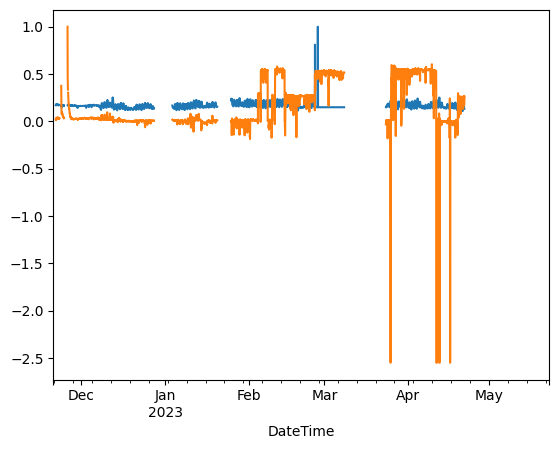

In [122]:
import numpy as np

max_temp_value = sensor_data['temperature'].max()
max_conc_value = sensor_data['measuring'].max()
sensor_data['temperature'].apply(lambda v: v/max_temp_value if not np.isnan(v) else v).plot()
sensor_data['measuring'].apply(lambda v: v/max_conc_value if not np.isnan(v) else v).plot()

## Tag concentration data according to environmental tag

In [123]:
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

def tag_by_env_tag(current_tag, env_tag):
    if current_tag != 'VALID': return current_tag
    if env_tag != 'VALID': return 'INVALID_ENV'
    return 'VALID'

tags_dataframe = sensor_data[['Tag', 'Temperature Tag']]
sensor_data['Tag'] = tags_dataframe.apply(lambda df: tag_by_env_tag(df[0], df[1]), axis=1)
tags = ['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID', 'LTQTLE01', 'GTQTLE99', 'INVALID_ENV']
data_contabilization = sensor_analysis.count_tags(tags, sensor_data)
data_contabilization

,#,%
MISSING,1194,6.766023
LTLL,1020,5.780019
GTUL,0,0.0
BADSPIKE,4437,25.143084
VALID,4028,22.825409
LTQTLE01,63,0.357001
GTQTLE99,58,0.328668
INVALID_ENV,156,0.884003
TOTAL,17647,100.0


<Axes: xlabel='DateTime'>

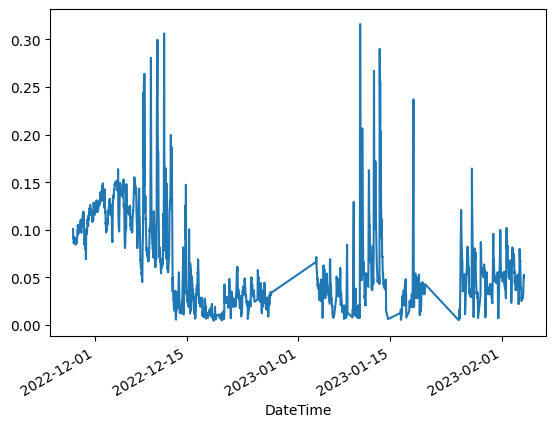

In [124]:
sensor_data[sensor_data['Tag'] == 'VALID']['measuring'].plot()

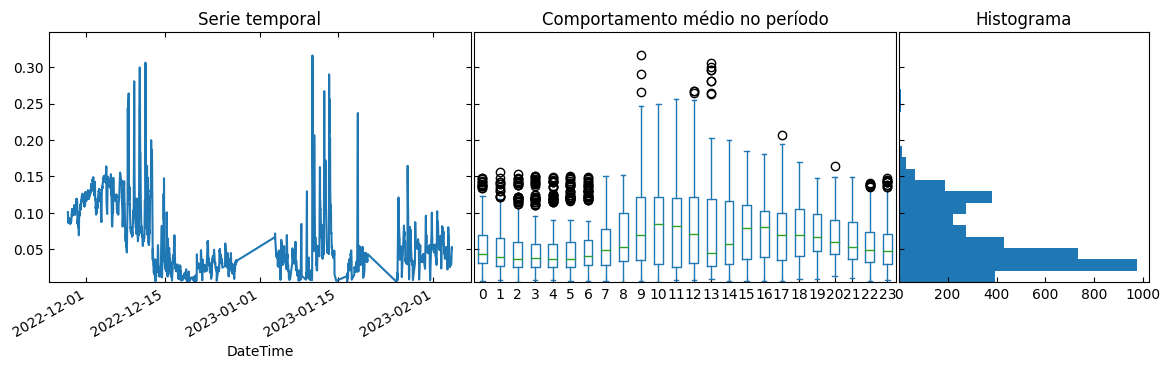

In [125]:
valid_dataframe = sensor_data[sensor_data['Tag'] == 'VALID'].drop(columns=['Tag', 'Temperature Tag'])
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Plot sensor vs. temperature

Spearmans correlation coefficient: 0.519
Samples are correlated (reject H0) p=0.000
Kendall correlation coefficient: 0.519
Samples are correlated (reject H0) p=0.000


Text(0.05, 0.9, "Kendall's tau=0.377, p<0.05")

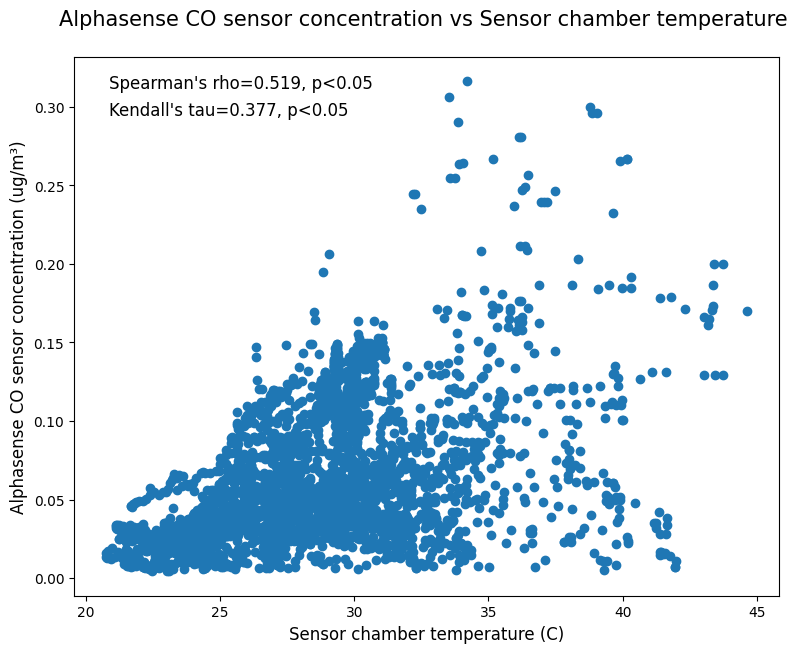

In [126]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))
plt.scatter(valid_dataframe['temperature'], valid_dataframe['measuring'])
plt.title('Alphasense CO sensor concentration vs Sensor chamber temperature \n', 
          fontdict={'fontsize':15})
plt.xlabel('Sensor chamber temperature (C)', 
           fontsize=12)
plt.ylabel('Alphasense CO sensor concentration (ug/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
coef, p = spearmanr(valid_dataframe['temperature'], valid_dataframe['measuring'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau( valid_dataframe['temperature'], valid_dataframe['measuring'], 
                            nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

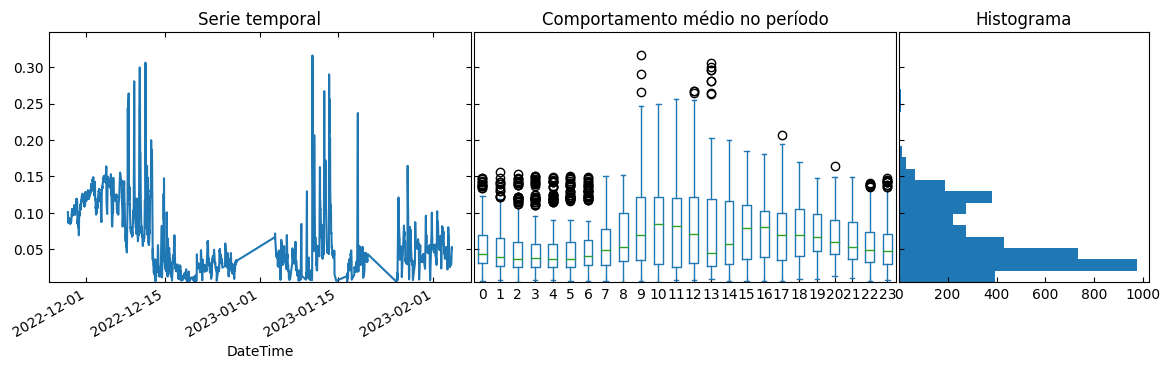

In [127]:
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Apply Kalman filter

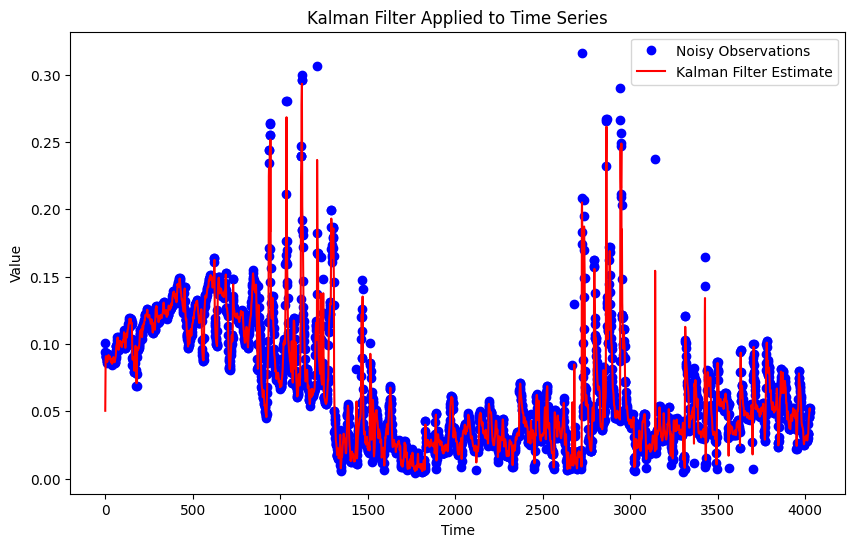

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Simulate noisy observations
observations = valid_dataframe['measuring'].to_numpy()

# Apply Kalman filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Estimate state and covariance matrices
state_means, state_covariances = kf.filter(observations)

# Plot the original data, true values, and the Kalman filter estimate
plt.figure(figsize=(10, 6))
plt.plot(observations, label='Noisy Observations', marker='o', linestyle='None', color='blue')
plt.plot(state_means, label='Kalman Filter Estimate', linestyle='-', color='red')

plt.title('Kalman Filter Applied to Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Axes: xlabel='DateTime'>

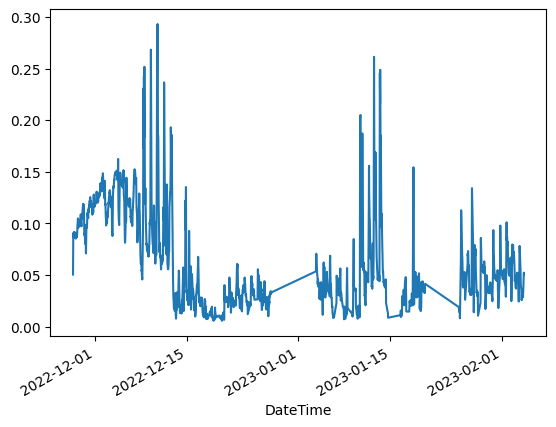

In [129]:
filter_series = pd.Series(state_means.flatten())
filter_series.index = valid_dataframe.index
valid_dataframe['raw measuring'] = valid_dataframe['measuring']
valid_dataframe['measuring'] = filter_series
filter_series.plot()

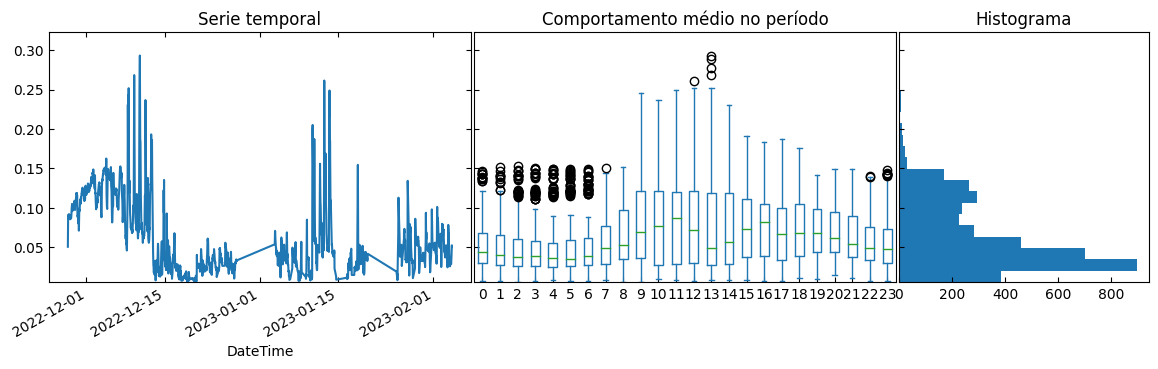

In [130]:
sensor_analysis.plot_box_hist(df=valid_dataframe, bins=20)

## Decompose signal

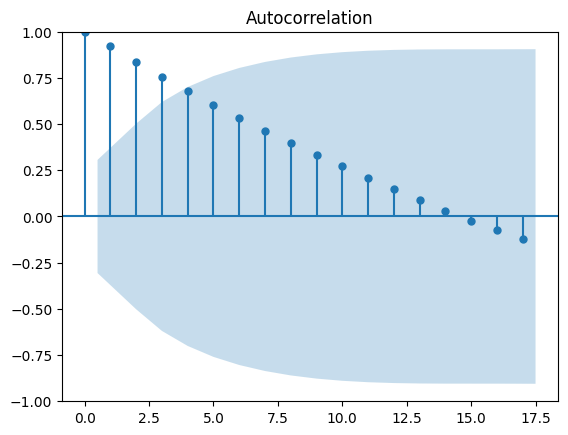

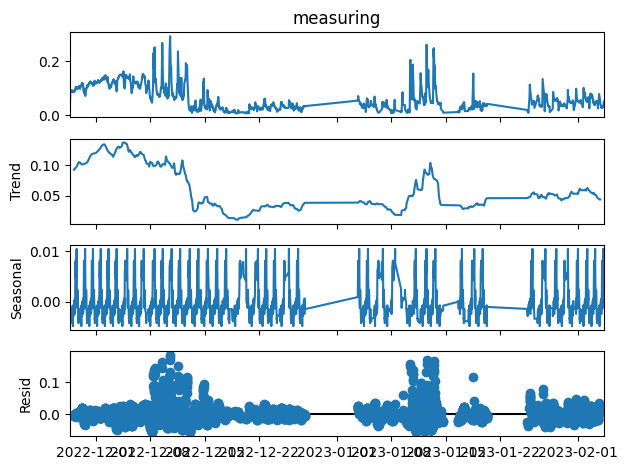

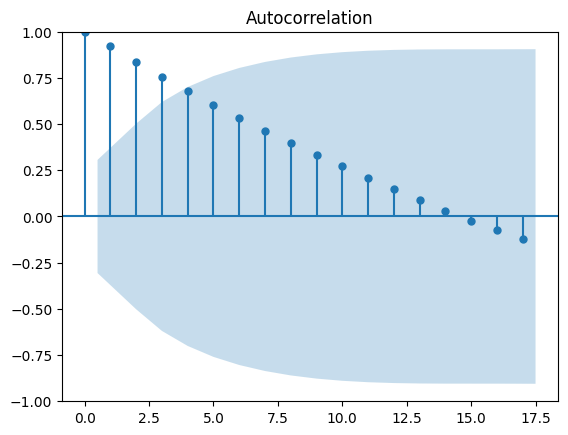

In [131]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

signal = seasonal_decompose(valid_dataframe['measuring'].fillna(value=valid_dataframe['measuring'].median()), 
                                 model='additive', period=4*24)
signal.plot()
tsaplots.plot_acf(acf(signal.resid.dropna(), nlags=40, fft=False))


### Analyse residuals

Shapiro-Wilk test p-value: 0.0
Shapiro-Wilk test statistic: 0.8252989053726196
Shapiro-Wilk test p-value: 0.0
The sample does not look normally distributed (reject H0)


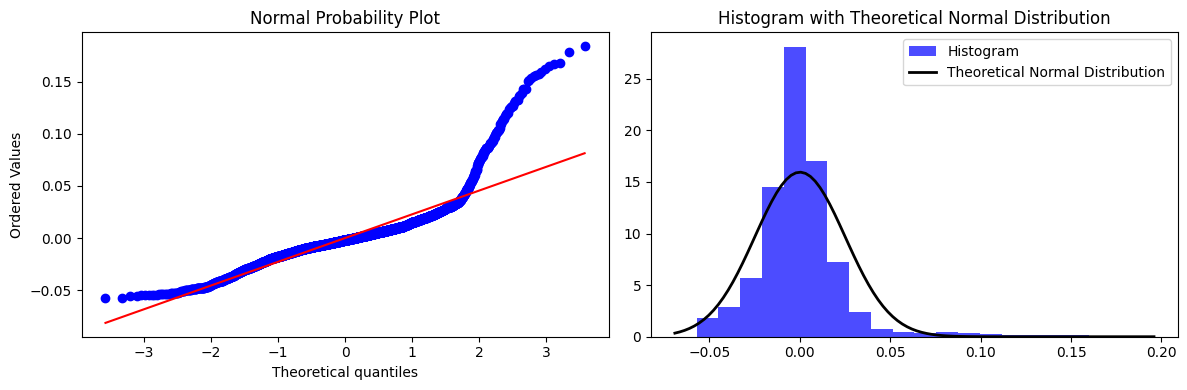

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot, shapiro

# Test for normality in the residuals
residuals = signal.resid.dropna()  # Drop NaN values introduced by decomposition

# Test for normality using Shapiro-Wilk test
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value}")

# Display the results
print(f"Shapiro-Wilk test statistic: {stat}")
print(f"Shapiro-Wilk test p-value: {p_value}")

# Check the null hypothesis
alpha = 0.05
if p_value > alpha:
    print("The sample looks normally distributed (fail to reject H0)")
else:
    print("The sample does not look normally distributed (reject H0)")

# Create a normal probability plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
probplot(residuals, plot=plt)
plt.title('Normal Probability Plot')

# Create a histogram with a theoretical normal distribution
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, density=True, alpha=0.7, color='blue', label='Histogram')

# Add a theoretical normal distribution to the histogram
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - np.mean(residuals)) / np.std(residuals))**2) / (np.std(residuals) * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2, label='Theoretical Normal Distribution')

plt.title('Histogram with Theoretical Normal Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [134]:
valid_dataframe['Trend'] = signal.trend
valid_dataframe['Seasonal Component'] = signal.seasonal
valid_dataframe['Residuals'] = signal.resid
valid_dataframe.head()

,measuring,Hour,temperature,raw measuring,Trend,Seasonal Component,Residuals
DateTime,,,,,,,
2022-11-27 17:00:00,0.050400,17,29.265,0.100800,NaN,-0.001179,NaN
2022-11-27 17:30:00,0.076362,17,30.005,0.093670,NaN,-0.001406,NaN
2022-11-27 17:45:00,0.086659,17,30.085,0.093095,NaN,-0.001384,NaN
2022-11-27 18:00:00,0.090634,18,30.120,0.093095,NaN,-0.001746,NaN
2022-11-27 18:15:00,0.090687,18,30.135,0.090720,NaN,-0.002195,NaN


### Analyse trend

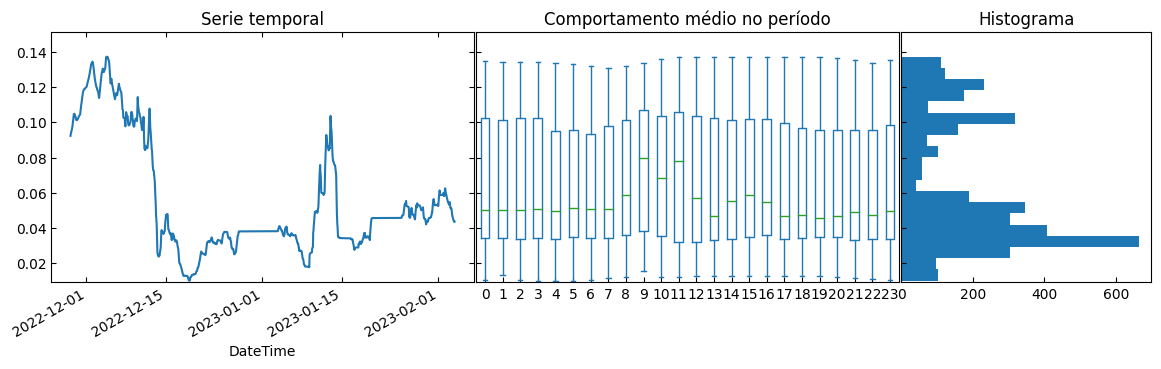

In [136]:
df = valid_dataframe[['Trend', 'Hour']].rename(columns={'Trend': 'measuring'})
sensor_analysis.plot_box_hist(df=df, bins=20)

# Resample Data

,measuring,Hour,temperature,raw measuring,Trend,Seasonal Component,Residuals,Count
DateTime,,,,,,,,
2022-11-27 17:30:00,0.071140,17,29.78500,0.095855,NaN,-0.001323,NaN,3
2022-11-27 18:30:00,0.090746,18,30.13125,0.091372,NaN,-0.002680,NaN,4
2022-11-27 19:30:00,0.088852,19,30.09375,0.088210,NaN,-0.003436,NaN,4
2022-11-27 20:30:00,0.087530,20,30.03750,0.087858,NaN,-0.001795,NaN,4
2022-11-27 21:30:00,0.090181,21,29.96875,0.090610,NaN,-0.003480,NaN,4


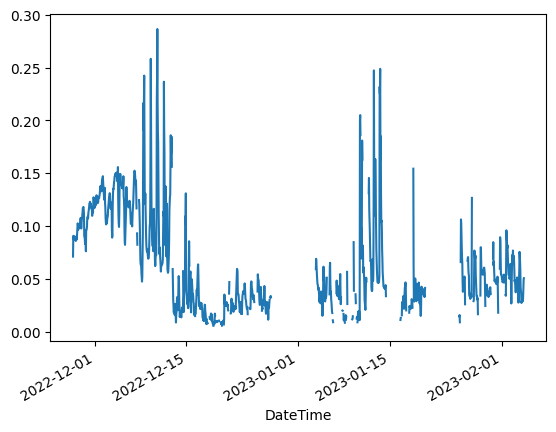

In [139]:
data_1HR = valid_dataframe.resample('H').mean()
data_1HR['Hour'] = data_1HR.index.hour
data_1HR['Count'] = (valid_dataframe['measuring'].resample('H').count())
data_1HR.index = data_1HR.index.map(lambda t: t.replace(minute=30, second=0))
data_1HR['measuring'].plot()
data_1HR.head()

#### Tag hourly data according to the number of samples in an hour
At least 3 samples must be valid in an hour (75 %) for the hourly data be considered as valid

<Axes: xlabel='DateTime'>

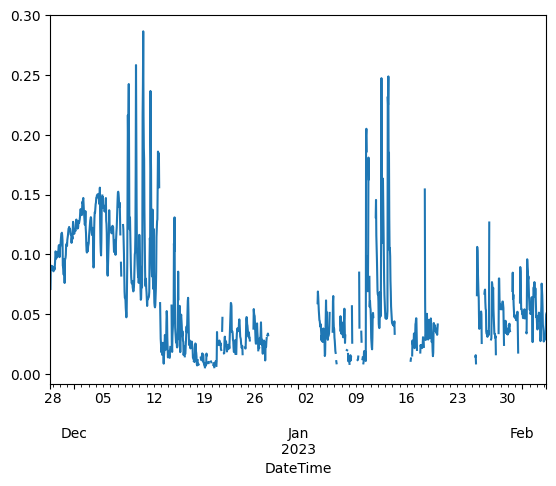

In [142]:
data_1HR['Tag'] = (data_1HR['Count'].map(lambda c: 'VALID' if c >= 3 else 'LOWSAMPLES'))
data_1HR['measuring'].resample('H').mean().plot()

#### Valid data contabilization

In [143]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, data_1HR)
data_contabilization

,#,%
LOWSAMPLES,666,40.412621
VALID,982,59.587379
TOTAL,1648,100.0


In [144]:
valid_data_1HR = data_1HR[data_1HR['Tag'] == 'VALID']

# Save Data

In [145]:
import os

output_directory_path = 'data/output/'
processing_directory_path = '../data-processing/input/'
valid_filename = '_and_temp_valid.csv'
valid_filename_1HR = '_and_temp_valid_1HR.csv'

valid_1HR_file_path_output = output_directory_path + SENSOR_NAME + valid_filename_1HR
valid_file_path_output = output_directory_path + SENSOR_NAME + valid_filename

valid_processing_1HR_file_path = processing_directory_path + SENSOR_NAME + valid_filename_1HR
valid_processing_file_path = processing_directory_path + SENSOR_NAME + valid_filename

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

if not os.path.exists(processing_directory_path):
    os.makedirs(processing_directory_path)

valid_dataframe.to_csv(valid_file_path_output)
valid_data_1HR.to_csv(valid_1HR_file_path_output)

valid_dataframe.to_csv(valid_processing_file_path)
valid_data_1HR.to_csv(valid_processing_1HR_file_path)